In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import numpy as np
import scipy
from scipy.interpolate import RegularGridInterpolator

import yaml
from tqdm import tqdm 

import os

import matplotlib.pyplot as plt
from neurorient.model import NeurOrient, NeurOrientLightning
from neurorient.utils_visualization import save_mrc, display_volumes, display_fsc, display_images
from neurorient.reconstruction.phasing import PhaseRetriever
from neurorient.metrics import compute_fsc
from neurorient.reconstruction.slicing import real_mesh_2_reciprocal_mesh

from sklearn.model_selection import train_test_split

import skopi as sk
import h5py
from pytorch3d.transforms import (
    matrix_to_quaternion, quaternion_to_matrix, so3_rotation_angle, so3_relative_angle,
    matrix_to_axis_angle
    )

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/skopi/diffraction.py:76: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_phase(atom_pos, q_xyz):
/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/skopi/diffraction.py:90: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def cal(f_hkl, atom_pos, q_xyz, xyz_ind, pixel_number):
/pscratch/sd/z

In [2]:
with open('/pscratch/sd/z/zhantao/neurorient_repo/experiments/experiments.yaml') as f:
    experiments = yaml.safe_load(f)

In [3]:
experiments['1bxr']

{'resnet18': {'f1_p1_g1_b1_c1': '/pscratch/sd/z/zhantao/neurorient_repo/experiments/transformations/lightning_logs/version_16755838/checkpoints/1BXR-epoch=532-step=15430.ckpt',
  'f1_p1_g1_b0_c1': '/pscratch/sd/z/zhantao/neurorient_repo/experiments/transformations/lightning_logs/version_16755837/checkpoints/1BXR-epoch=634-step=18390.ckpt',
  'f1_p1_g1_b0_c0': '/pscratch/sd/z/zhantao/neurorient_repo/experiments/transformations/lightning_logs/version_16755836/checkpoints/1BXR-epoch=840-step=24370.ckpt',
  'f1_p1_g0_b0_c0': '/pscratch/sd/z/zhantao/neurorient_repo/experiments/transformations/lightning_logs/version_16755834/checkpoints/1BXR-epoch=896-step=25990.ckpt'},
 'bifpn18': {'f1_p1_g1_b1_c1': '/pscratch/sd/z/zhantao/neurorient_repo/experiments/transformations/lightning_logs/version_16755810/checkpoints/1BXR-epoch=842-step=24420.ckpt',
  'f1_p1_g1_b0_c1': '/pscratch/sd/z/zhantao/neurorient_repo/experiments/transformations/lightning_logs/version_16755812/checkpoints/1BXR-epoch=891-step

In [4]:
pdb = '1BXR'
poisson = True
num_images = 10000
increase_factor = 10

In [5]:
spi_data = torch.load(f'/pscratch/sd/z/zhantao/neurorient_repo/data/{pdb}_increase{increase_factor:d}_poisson{poisson}_num{num_images//1000:d}K.pt')
ckpt_path = experiments[pdb.lower()]['bifpn18']['f1_p1_g0_b0_c1']
save_dir = '/pscratch/sd/z/zhantao/neurorient_repo/data'
print(spi_data.keys())

dict_keys(['orientations', 'intensities', 'pixel_position_reciprocal', 'pixel_index_map', 'volume', 'img_real_mesh', 'vol_real_mesh', 'time_stamp'])


In [6]:
model = NeurOrientLightning.load_from_checkpoint(ckpt_path)

In [78]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

def visualize_3d_slice_with_matplotlib(coordinates, image_slice, vmax=None):
    # Ensure image values are between 0 and 1
    image_slice_normalized = image_slice / np.max(image_slice)
    if vmax is not None:
        image_slice_normalized = np.clip(image_slice_normalized, None, vmax/np.max(image_slice))
        image_slice_normalized = image_slice_normalized / np.max(image_slice_normalized)
    
    x = coordinates[0].flatten().reshape(image_slice.shape)
    y = coordinates[1].flatten().reshape(image_slice.shape)
    z = coordinates[2].flatten().reshape(image_slice.shape)

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Displaying the image slice as a surface
    surf = ax.plot_surface(x, y, z, facecolors=plt.cm.viridis(image_slice_normalized), rstride=1, cstride=1,
                           antialiased=True, shade=False)
    
    # Set equal aspect ratios
    ax.set_xlim3d(-np.pi, np.pi)
    ax.set_ylim3d(-np.pi, np.pi)
    ax.set_zlim3d(-np.pi, np.pi)
    ax.set_box_aspect([1, 1, 1])
    
    ax.set_xticks(np.pi * np.linspace(-1, 1, 5))
    ax.set_yticks(np.pi * np.linspace(-1, 1, 5))
    ax.set_zticks(np.pi * np.linspace(-1, 1, 5))
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    ax.set_xlabel('$x$', fontsize=16)
    ax.set_ylabel('$y$', fontsize=16)
    ax.set_zlabel('$z$', fontsize=16)
    
    
    plt.show()  

In [8]:
from neurorient.reconstruction.slicing import gen_nonuniform_normalized_positions

In [54]:
i = 6
images = spi_data['intensities'][i].numpy()
coords = gen_nonuniform_normalized_positions(spi_data['orientations'][i:i+1], spi_data['pixel_position_reciprocal'], oversampling=1).numpy()



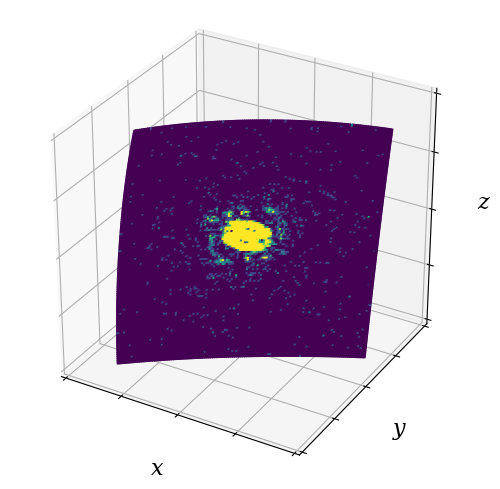

In [79]:
visualize_3d_slice_with_matplotlib(coords, images, vmax=5)